## import libraries

In [1]:
# Libraries and setup

# Auto reload changes
%load_ext autoreload
%autoreload 2

from src.utils.dependencies import *

import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

# log file schema
from src.log_file_schema import schema

# data handler
from src.data_handler import DataHandler
dh = DataHandler()
n=5

Importing plotly failed. Interactive plots will not work.


## Create or Get Spark session

In [2]:
#create or get spark session
spark = SparkSession.builder \
    .master("local[*]")\
    .appName("PayPayChallenge")\
    .getOrCreate()

In [3]:
def preprocess_data(spark):
    
    df = spark.read.csv(log_file, schema=schema, sep=" ").repartition(num_partitions).cache()
    
    #df2=df.withColumn("time", col("timestamp").cast("timestamp")).drop("client:port","backend:port","request","timestamp", "elb", "request_processing_time", "backend_processing_time", "response_processing_time", "elb_status_code", "backend_status_code", "received_bytes", "sent_bytes", "user_agent", "ssl_cipher", "ssl_protocol").cache().
    df=df.withColumn("time", col("timestamp").cast("timestamp")).withColumn("load",lit(1)).drop("client:port",
                                                                                                "backend:port","request","timestamp", "elb", "request_processing_time", 
                                                                                                "backend_processing_time", "response_processing_time", "elb_status_code", 
                                                                                                "backend_status_code", "received_bytes", "sent_bytes", "user_agent", 
                                                                                                "ssl_cipher", "ssl_protocol");
    
    df=df.withColumn("time", from_unixtime(unix_timestamp(col("time"), "yyyy-MM-dd HH:mm:ss.SSSSSS"),"yyyy-MM-dd HH:mm:ss"));
    df = df.groupby("time").agg(sum("load").alias("load")).cache()
    df=df.orderBy(col("time"))
    return df


def data_loader(spark):
    dataset1 = preprocess_data(spark).cache()
    dataset1.show()
    return dataset1.select("*").toPandas()

df=data_loader(spark)

+-------------------+----+
|               time|load|
+-------------------+----+
|2015-07-22 11:40:06|  27|
|2015-07-22 11:40:07|  62|
|2015-07-22 11:40:08|  56|
|2015-07-22 11:40:09| 112|
|2015-07-22 11:40:10|  58|
|2015-07-22 11:40:11|  58|
|2015-07-22 11:40:12|  67|
|2015-07-22 11:40:13|  85|
|2015-07-22 11:40:14| 160|
|2015-07-22 11:40:15|  57|
|2015-07-22 11:40:16|  99|
|2015-07-22 11:40:17|  96|
|2015-07-22 11:40:18|  95|
|2015-07-22 11:40:19|  65|
|2015-07-22 11:40:20| 130|
|2015-07-22 11:40:21|  65|
|2015-07-22 11:40:22|  59|
|2015-07-22 11:40:23|  62|
|2015-07-22 11:40:24|  89|
|2015-07-22 11:40:25| 130|
+-------------------+----+
only showing top 20 rows



In [4]:
print(df.shape)

(4269, 2)


In [5]:
data_dateIndexed=df.set_index("time");
data_dateIndexed_train = data_dateIndexed[:-600]
data_dateIndexed_test = data_dateIndexed[-600:]

data_dateIndexed_train=data_dateIndexed_train[["load"]];
data_dateIndexed_test=data_dateIndexed_test[["load"]];

print(data_dateIndexed_train.shape)
print(data_dateIndexed_test.shape)
print(data_dateIndexed_train.shape[0]+data_dateIndexed_test.shape[0])

(3669, 1)
(600, 1)
4269


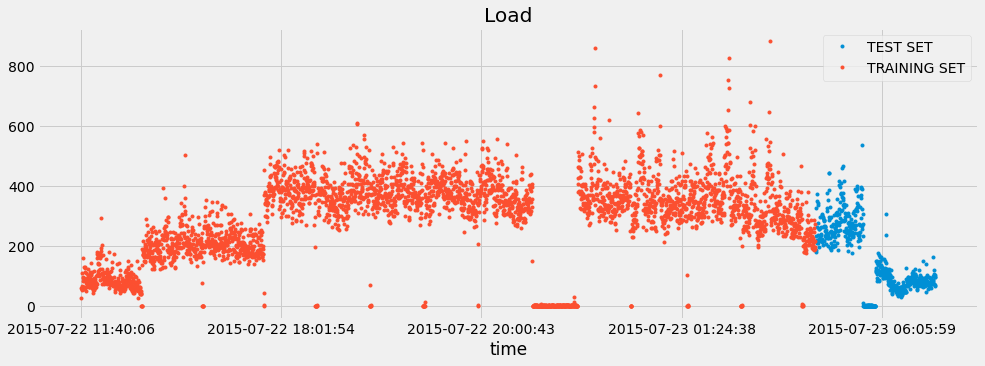

In [6]:
_ = data_dateIndexed_test \
    .rename(columns={'load': 'TEST SET'}) \
    .join(data_dateIndexed_train.rename(columns={'load': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Load', style='.')

In [7]:
data_dateIndexed_train.reset_index().rename(columns={'time':'x', 'load':'y'}).head()

,x,y
0,2015-07-22 11:40:06,27
1,2015-07-22 11:40:07,62
2,2015-07-22 11:40:08,56
3,2015-07-22 11:40:09,112
4,2015-07-22 11:40:10,58


In [8]:
model = Prophet()
model.fit(data_dateIndexed_train.reset_index().rename(columns={'time':'ds', 'load':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
data_dateIndexed_test_fcst = model.predict(df=data_dateIndexed_test.reset_index().rename(columns={'time':'ds'}))

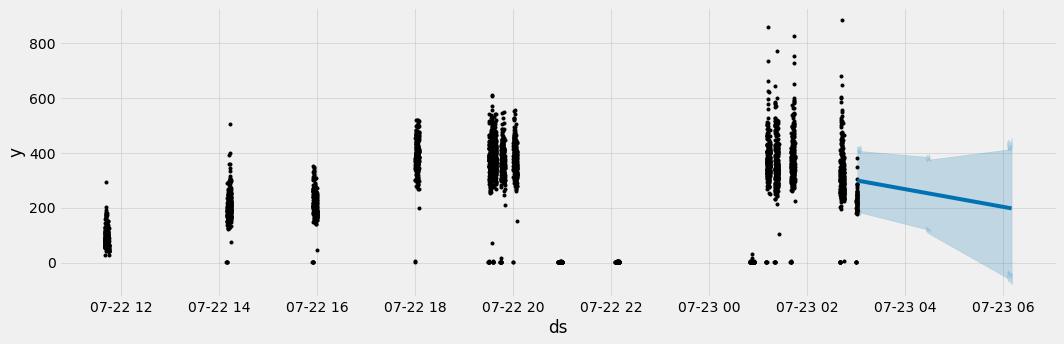

In [10]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(data_dateIndexed_test_fcst, ax=ax)

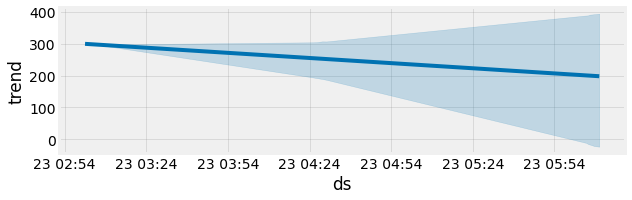

In [11]:
fig = model.plot_components(data_dateIndexed_test_fcst)


In [12]:
mean_squared_error(y_true=data_dateIndexed_test['load'],
                   y_pred=data_dateIndexed_test_fcst['yhat'])

14894.452175545066

In [13]:
mean_absolute_error(y_true=data_dateIndexed_test['load'],
                   y_pred=data_dateIndexed_test_fcst['yhat'])




103.63974055772356